In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import warnings
warnings.filterwarnings('ignore', 'lbfgs failed to converge*')

import aug_functions

In [2]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'serif'})
rc('text', usetex=True)
rc('text.latex', preamble='''
        \\usepackage[utf8]{inputenc}
        \\usepackage{amssymb}
        \\usepackage{amsfonts}
        \\usepackage[russian]{babel}''')

In [3]:
good_objects_df = pd.read_csv("../data/plasticc/good_objects.csv", index_col=0)
good_objects_df.sample(10)

,object_id,mjd,passband,flux,flux_err,detected,log_lam,class
2506827,80192,60003.2462,3,18.629541,1.724908,1,3.875155,0
5992997,189724,59842.0838,3,43.258259,1.282086,1,3.875155,1
8677569,274500,59873.0289,1,7.304835,0.775145,1,3.675929,1
6693833,211734,60608.0836,2,28.520067,0.916725,1,3.790512,0
92688,49529,60662.1451,2,181.712723,1.604320,1,3.790512,0
36266,18556,60297.1169,2,166.916016,1.794018,1,3.790512,0
3268883,104761,59884.1292,2,19.934641,0.951091,1,3.790512,0
3248180,53884302,59949.1120,4,152.524597,15.599266,1,3.938479,0
3385443,108419,60606.0967,4,18.794933,2.163719,1,3.938479,1
191234,99280,59899.0383,2,4.102321,0.707051,1,3.790512,0


In [4]:
good_object_ids = np.unique(good_objects_df.object_id)

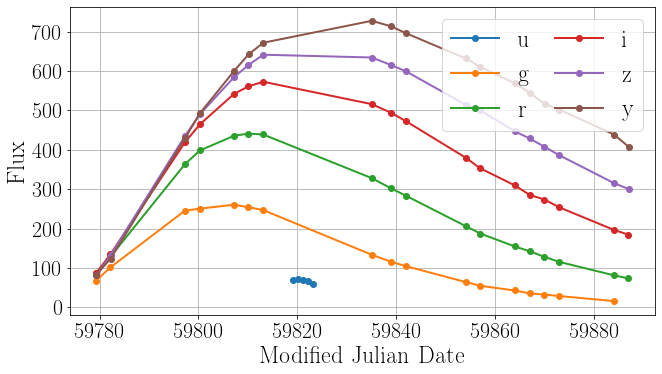

In [5]:
anobject = aug_functions.get_object(good_objects_df, 34299)

aug_functions.plot_light_curves(anobject)

In [6]:
augmentation_model = "GP"

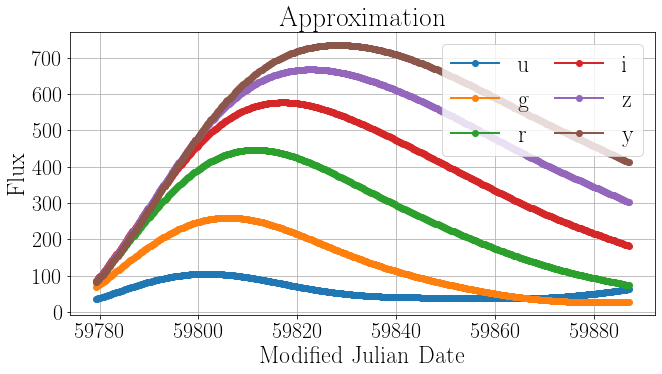

In [7]:
from sklearn.model_selection import train_test_split

anobject = aug_functions.get_object(good_objects_df, 34299)
anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

# fit augmentation model
model = None
if augmentation_model == "GP":
    import gp_aug
    model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
elif augmentation_model == "NN_single":
    import single_layer_aug
    model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
elif augmentation_model == "FE":
    import features_aug
    model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
elif augmentation_model == "MLP":
    import mlp_reg_aug
    model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
else:
    raise ValueError("Unknown augmentation type: {}".format(augmentation_model))
    
# fit augmentation model
model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)

# predict flux for unseen observations
flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, anobject_test['passband'].values, copy=True)

# augmentation
t_aug, flux_aug, flux_err, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                              anobject['mjd'].max(), 
                                                              n_obs=aug_functions.N_OBS)
anobject_test_pred = aug_functions.compile_obj(anobject_test['mjd'].values, 
                                               flux_pred, anobject_test['passband'].values)
anobject_aug = aug_functions.compile_obj(t_aug, flux_aug, passbands_aug)
aug_functions.plot_light_curves(anobject_aug, "Approximation")

In [8]:
from tqdm.notebook import tqdm

all_data = []
all_target_classes = []
for good_id in tqdm(good_object_ids):
    anobject = aug_functions.get_object(good_objects_df, good_id)
    anobject_train, anobject_test = train_test_split(anobject, test_size=0.36, random_state=11)

    # initialize augmentation model
    model = None
    if augmentation_model == "GP":
        model = gp_aug.GaussianProcessesAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "NN_single":
        model = single_layer_aug.SingleLayerNetAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "FE":
        model = features_aug.FeaturesEngineeringAugmentation(aug_functions.passband2lam)
    elif augmentation_model == "MLP":
        model = mlp_reg_aug.MLPRegressionAugmentation(aug_functions.passband2lam)
    else:
        raise ValueError("Unknown augmentation type")

    # fit augmentation model
    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

    # predict flux for unseen observations
    flux_pred, flux_err_pred = model.predict(anobject_test['mjd'].values, 
                                             anobject_test['passband'].values, copy=True)

    # augmentation
    t_aug, flux_aug, flux_err, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=aug_functions.N_OBS)

    data_array = flux_aug.reshape((aug_functions.N_PASSBANDS, aug_functions.N_OBS)).T
    all_data.append([data_array])
    
    true_class = int(anobject['class'].to_numpy()[0])
    all_target_classes.append(true_class)
    
all_data = np.array(all_data)
all_target_classes = np.array(all_target_classes)
print(all_data.shape, all_target_classes.shape)

  0%|          | 0/2508 [00:00<?, ?it/s]

(2508, 1, 500, 6) (2508,)


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'

In [10]:
X_train, X_test, y_train, y_test = train_test_split(all_data, 
                                                    all_target_classes,
                                                    test_size=0.4,
                                                    random_state=179)

# normalize input
X_train_norm = np.array((X_train - X_train.mean()) / X_train.std(), dtype=np.float32)
X_test_norm = np.array((X_test - X_train.mean()) / X_train.std(), dtype=np.float32)

X_train_tensor = torch.from_numpy(X_train_norm)
y_train_tensor = torch.from_numpy(np.array(y_train, dtype=np.float32))

train_data = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)

X_test_tensor = torch.from_numpy(X_test_norm)
y_test_tensor = torch.from_numpy(np.array(y_test, dtype=np.float32))

test_data = TensorDataset(X_test_tensor, y_test_tensor)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(10, 2))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(10, 2))
        self.conv3 = nn.Conv1d(8, 16, kernel_size=(5, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(3824, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = x.view(-1, 3824)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
import torch.optim as optim

net = Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)

In [13]:
from scipy.special import expit

def get_model_accuracy(net, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for test_info in data_loader:
            images, test_labels = test_info
            test_outputs = net(images)
            prob = expit(test_outputs.item())
            if prob > 0.5:
                predicted = 1
            else:
                predicted = 0
            total += test_labels.size(0)
            correct += (predicted == test_labels.item())

    return correct / total

In [14]:
epochs = np.arange(100)

for epoch in tqdm(epochs):  # loop over the dataset multiple times
    epoch_loss = 0.0
    for info in trainloader:
        # get the inputs; info is a list of [inputs, labels]
        inputs, labels = info

        # zero the parameter gradients
        for param in net.parameters():
            param.grad = None
        
        # forward + backward + optimize
        outputs = net(inputs).reshape(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # print mean loss for the epoch
    cur_loss = epoch_loss / X_train_norm.shape[0]
    if (epoch + 1) % 10 == 0:
        print('[%5d] error: %.3f' % (epoch + 1, cur_loss))

print('Finished Training')

  0%|          | 0/100 [00:00<?, ?it/s]

[   10] error: 0.687
[   20] error: 0.520
[   30] error: 0.367
[   40] error: 0.224
[   50] error: 0.137
[   60] error: 0.124
[   70] error: 0.094
[   80] error: 0.094
[   90] error: 0.072
[  100] error: 0.065
Finished Training


In [15]:
test_accuracy = get_model_accuracy(net, testloader)
train_accuracy = get_model_accuracy(net, trainloader)

print('Test accuracy of the network on the %d test images: %.4f' % 
      (X_test_norm.shape[0], test_accuracy))
print('Train accuracy of the network on the %d train images: %.4f' % 
      (X_train_norm.shape[0], train_accuracy))

Test accuracy of the network on the 1004 test images: 0.9283
Train accuracy of the network on the 1504 train images: 0.9521


In [16]:
y_test = []
y_probs = []
y_probs_0 = []
y_probs_1 = []

with torch.no_grad():
    for test_info in testloader:
        images, test_labels = test_info
        test_outputs = net(images)
        prob = expit(test_outputs.item())
            
        true_class = int(test_labels.item())
        if true_class == 0:
            y_probs_0.append(prob)
        else:
            y_probs_1.append(prob)

        y_test.append(true_class)
        y_probs.append(prob)

In [17]:
from sklearn.metrics import log_loss
y_pred = np.array(y_probs) > 0.5
print("LogLoss = %.4f" % log_loss(y_test, y_pred))

LogLoss = 2.5801


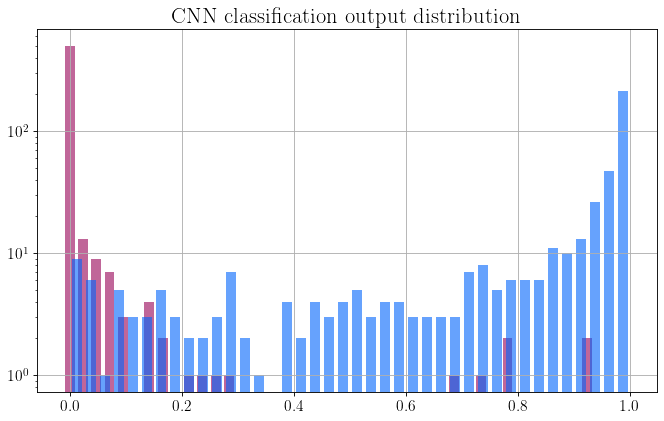

In [18]:
fig = plt.figure(dpi=80, figsize=(10, 6))
plt.title("CNN classification output distribution", fontsize=20)
plt.xticks(fontsize=14, color="black")
plt.yticks(fontsize=14, color="black")
plt.grid(True)
plt.hist(y_probs_0, bins=40, color="xkcd:dark magenta", align="left", rwidth=0.75, alpha=0.6, log=True)
plt.hist(y_probs_1, bins=40, color="xkcd:bright blue", rwidth=0.75, alpha=0.6, log=True)
plt.show()
fig.savefig("../pictures/CNN_output_hist_{}.pdf".format(augmentation_model),
           bbox_inches='tight', pad_inches=0.01)

Test ROC-AUC: 0.9913, test PR-AUC: 0.9898


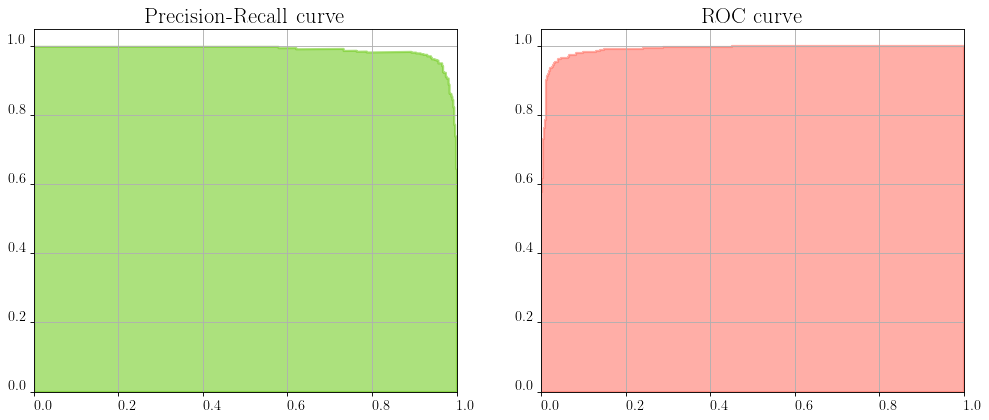

In [19]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

DPI = 80
SIZE_X, SIZE_Y = 15, 6

print("Test ROC-AUC: %.4f, test PR-AUC: %.4f" % (roc_auc_score(y_test, y_probs), 
                                                 average_precision_score(y_test, y_probs)))

precision, recall, _ = precision_recall_curve(y_test, y_probs)

fig = plt.figure(dpi=80, figsize=(15, 6))
ax = fig.add_subplot(121)
plt.grid(True)
plt.xticks(color="black", fontsize=13, ha="left")
plt.yticks(color="black", fontsize=13, va="bottom")
ax.set_title("Precision-Recall curve", fontsize=20, color="black")
ax.fill_between(recall, precision, alpha=0.6, color="xkcd:apple green", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

ax = fig.add_subplot(122)
plt.grid(True)
plt.xticks(color="black", fontsize=13, ha="left")
plt.yticks(color="black", fontsize=13, va="bottom")
ax.set_title("ROC curve", fontsize=20, color="black")
ax.fill_between(fpr, tpr, alpha=0.6, color="xkcd:salmon", lw=2)
ax.set_xlim(0, 1.)
ax.set_ylim(0, 1.05)

fig.savefig("../pictures/CNN_pr_roc_curves_{}.pdf".format(augmentation_model), 
            bbox_inches='tight', pad_inches=0.01)